# Project for course "Artificial Intelligence for Engineers DAT305"

## Task 4: Detecting Dementia Using Natural Language Processing

### This project aims to develop several predictive models for detecting dementia using Natural Language Processing (NLP). 

### Group members: Daniil Krichevskiy, Sylvester Morka

In [8]:
#import necessary packages

import numpy as np
import pandas as pd
import spacy
import nltk
import seaborn as sns
import nlpaug.augmenter.word as naw

import re

from nltk.corpus import stopwords

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold

from transformers import AdamW, BertTokenizer, BertModel
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split


from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW

# 1. Data preprocessing

In [502]:
#read the training datasets for patients with and without dementia and combine them into a single training dataframe

control_df = pd.read_csv("Data/Control_db.csv")   #data for patients with dementia
dementia_df = pd.read_csv("Data/Dementia_db.csv") #data for patients with no dementia

#training set
train = pd.concat([control_df,dementia_df], axis=0)
train.head()

,Language,Data,Participant,Age,Gender,Diagnosis,Category,mmse,Filename,Transcript
0,eng,Pitt,PAR,74,male,Control,0,NaN,S001,well there's a mother standing there &uh &uh ...
1,eng,Pitt,PAR,62,female,Control,0,30.0,S002,somebody's getting cookies out_of the cookie ...
2,eng,Pitt,PAR,69,female,Control,0,29.0,S003,okay . there's a little boy and <he's getting...
3,eng,Pitt,PAR,71,female,Control,0,30.0,S004,are you ready ? &um well the sink is overflow...
4,eng,Pitt,PAR,74,female,Control,0,30.0,S005,okay . <many &dish or> [//] the mother's wash...


In [504]:
#read the testing dataset 
test = pd.read_csv("Data/Testing_db.csv") 
test.head()

,Data,Participant,Age,Gender,Diagnosis,Category,mmse,Filename,Transcript
0,Pitt,PAR,63,female,Control,0,28,S160,&uh this boy is about to fall off o(f) the st...
1,Pitt,PAR,55,female,Control,0,29,S161,&uh a boy with a cookie in his one hand and h...
2,Pitt,PAR,67,female,ProbableAD,1,24,S162,"I see &uh two kids up at the cookie jar, one ..."
3,Pitt,PAR,71,male,Control,0,30,S163,okay the water's running out_of the sink over...
4,Pitt,PAR,73,female,ProbableAD,1,21,S164,well he's into the cookie jar and the [/] the...


In [506]:
#get basic information about the training dataframe
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108 entries, 0 to 53
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Language     108 non-null    object 
 1   Data         108 non-null    object 
 2   Participant  108 non-null    object 
 3   Age          108 non-null    int64  
 4   Gender       108 non-null    object 
 5   Diagnosis    108 non-null    object 
 6   Category     108 non-null    int64  
 7   mmse         107 non-null    float64
 8   Filename     108 non-null    object 
 9   Transcript   108 non-null    object 
dtypes: float64(1), int64(2), object(7)
memory usage: 9.3+ KB


In [508]:
#get basic information about the testing dataframe
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Data         48 non-null     object
 1   Participant  48 non-null     object
 2   Age          48 non-null     int64 
 3   Gender       48 non-null     object
 4   Diagnosis    48 non-null     object
 5   Category     48 non-null     int64 
 6   mmse         48 non-null     int64 
 7   Filename     48 non-null     object
 8   Transcript   48 non-null     object
dtypes: int64(3), object(6)
memory usage: 3.5+ KB


In [510]:
#we only keep some of the columns
train = train[["Age","Gender","mmse","Category","Transcript"]]
test = test[["Age","Gender","mmse","Category","Transcript"]]

#convert 'Gender' column to binary values (female -> 1, male -> 0)
train['Gender'] = train['Gender'].apply(lambda x: 1 if x == 'female' else 0)
test['Gender'] = test['Gender'].apply(lambda x: 1 if x == 'female' else 0)

In [512]:
#show all rows with at least 1 missing value
print(train[train.isnull().any(axis=1)])

print(test[test.isnull().any(axis=1)])

   Age  Gender  mmse  Category  \
0   74       0   NaN         0   

                                          Transcript  
0   well there's a mother standing there &uh &uh ...  
Empty DataFrame
Columns: [Age, Gender, mmse, Category, Transcript]
Index: []


We see that in the dataframe `train` there is one missing value in the `mmse`column. We replace it with the average value of mmse calculated for patients within 0 category (in this dataframe)

In [515]:
#calculate the mean value of mmse for rows where Category is 0 and Gender is 0, rounded to the nearest integer
mean_mmse = round(train[(train['Category'] == 0) & (train['Gender'] == 0)]['mmse'].mean())

#fill missing values in mmse where category is 0 with the calculated mean
train.loc[(train['mmse'].isnull()) & (train['Category'] == 0) & (train['Gender'] == 0), 'mmse'] = mean_mmse

### Preprocessing of transcripts

In [518]:
#remove punctuation from the 'Transcript' column
train['Transcript'] = train['Transcript'].str.replace(r'[^\w\s]', '', regex=True)
test['Transcript'] = test['Transcript'].str.replace(r'[^\w\s]', '', regex=True)

#replace all underscores with spaces
train['Transcript'] = train['Transcript'].str.replace('_', ' ')
test['Transcript'] = test['Transcript'].str.replace('_', ' ')

#convert all text in the 'Transcript' column to lowercase
train['Transcript'] = train['Transcript'].str.lower()
test['Transcript'] = test['Transcript'].str.lower()

In [520]:
#load SpaCy's English model for lemmatization
nlp = spacy.load("en_core_web_sm")

#function to lemmatize text
def lemmatize_text(text):
    # Process the text with SpaCy
    doc = nlp(text)
    # Lemmatize each token and join back into a single string
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

#apply the lemmatization function to the 'Transcript' column
train['Transcript'] = train['Transcript'].apply(lemmatize_text)
test['Transcript'] = test['Transcript'].apply(lemmatize_text)

#remove numbers from the 'Transcript' column
train['Transcript'] = train['Transcript'].str.replace(r'\d+', '', regex=True)
test['Transcript'] = test['Transcript'].str.replace(r'\d+', '', regex=True)

#remove single characters that are isolated (e.g., "s", "c") from the 'Transcript' column
train['Transcript'] = train['Transcript'].str.replace(r'\b[a-zA-Z]\b', '', regex=True)
test['Transcript'] = test['Transcript'].str.replace(r'\b[a-zA-Z]\b', '', regex=True)

#remove extra spaces that might be left after removing single letters and numbers
train['Transcript'] = train['Transcript'].str.replace(r'\s+', ' ', regex=True).str.strip()
test['Transcript'] = test['Transcript'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [522]:
#delete stop words
stop_words = set(stopwords.words('english'))

#function to remove stop words
def remove_stopwords(text):
    # Преобразуем текст в список слов, исключая стоп-слова
    filtered_text = " ".join([word for word in text.split() if word.lower() not in stop_words])
    return filtered_text

train['Transcript'] = train['Transcript'].apply(remove_stopwords)
test['Transcript'] = test['Transcript'].apply(remove_stopwords)

In [524]:
train.head()

,Age,Gender,mmse,Category,Transcript
0,74,0,29.0,0,well mother stand uh uh wash dish uh window op...
1,62,1,30.0,0,somebodys get cookie cookie jar stand stool go...
2,69,1,29.0,0,okay little boy get stand get cookie share coo...
3,71,1,30.0,0,ready um well sink overflow mother stand water...
4,74,1,30.0,0,okay many dish mother wash dish sink uh dry al...


# 2. Exploratory Analysis

We analyze the dataset for balance and adequacy. Specifically, we want to ensure:
- Gender distribution is balanced (no significant dominance of males or females).
- Age distribution is reasonable and doesn’t have extreme skews.
- Category distribution (Control vs Dementia) is balanced.

By performing this analysis, we can confirm whether the data is appropriate for building a robust model or if additional preprocessing (e.g., oversampling, undersampling) is necessary.

In [528]:
#calculate percentage of each gender
gender_percentage = train['Gender'].value_counts(normalize=True) * 100
print("\nGender Percentage:")
print(gender_percentage)


Gender Percentage:
Gender
1    55.555556
0    44.444444
Name: proportion, dtype: float64


In [530]:
#analyze category distribution
category_distribution = train['Category'].value_counts(normalize=True) * 100
print("Category Distribution:")
print(category_distribution)

Category Distribution:
Category
0    50.0
1    50.0
Name: proportion, dtype: float64


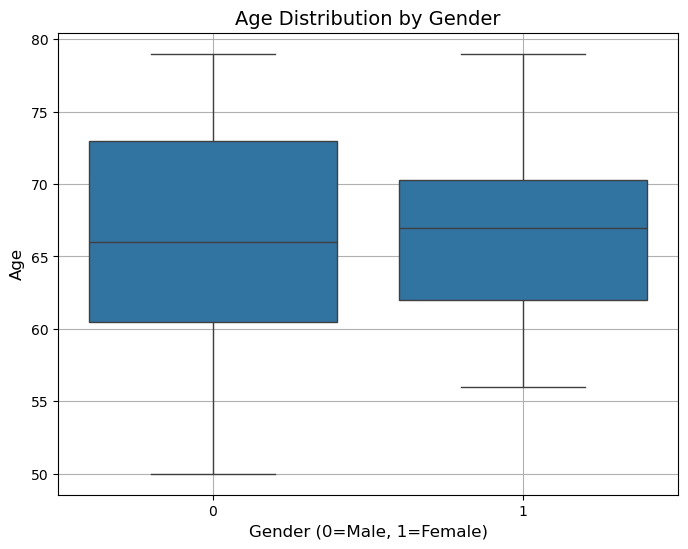

In [532]:
#plot of age grouped by gender
plt.figure(figsize=(8, 6))
sns.boxplot(x='Gender', y='Age', data=train)  # Create a boxplot to compare age distribution by gender
plt.title("Age Distribution by Gender", fontsize=14)  # Set the title of the plot
plt.xlabel("Gender (0=Male, 1=Female)", fontsize=12)  # Label for x-axis
plt.ylabel("Age", fontsize=12)  # Label for y-axis
plt.grid(True)  # Add a grid for better readability
plt.show()

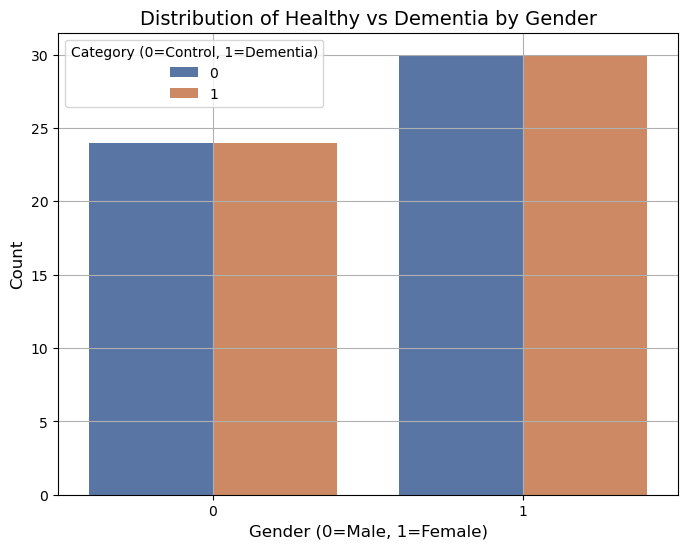

In [534]:
# Group by Gender and Category to calculate distribution
category_gender_distribution = train.groupby(['Gender', 'Category']).size().reset_index(name='Count')


# Create a barplot for visualizing the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x='Gender', y='Count', hue='Category', data=category_gender_distribution, palette="deep")
plt.title("Distribution of Healthy vs Dementia by Gender", fontsize=14)
plt.xlabel("Gender (0=Male, 1=Female)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Category (0=Control, 1=Dementia)")
plt.grid(True)
plt.show()

We observe the following:
- The number of females and males is approximately equal in both the healthy group and the dementia group.
- Within each gender , the number of individuals in the Control group (Category = 0) and the Dementia group (Category = 1) is balanced. There is no clear dominance of one category over the other within each gender.
- Males have a slightly higher median age and a wider age range compared to females. Both genders have minimal outliers, and the age distribution appears balanced and suitable for further analysis.

The dataset is balanced in terms of gender, age and health status. This ensures that the dataset does not have bias based on gender or category distribution, which is ideal for building a robust machine learning model. No additional adjustments are required at this stage.

## Analyzing the predictors

Now we will analyze the dataset to identify which features are strong predictors of dementia and which are not. This involves examining correlations between variables and visualizing their relationships. Understanding these relationships will help us determine which features are most relevant for building an accurate predictive model.

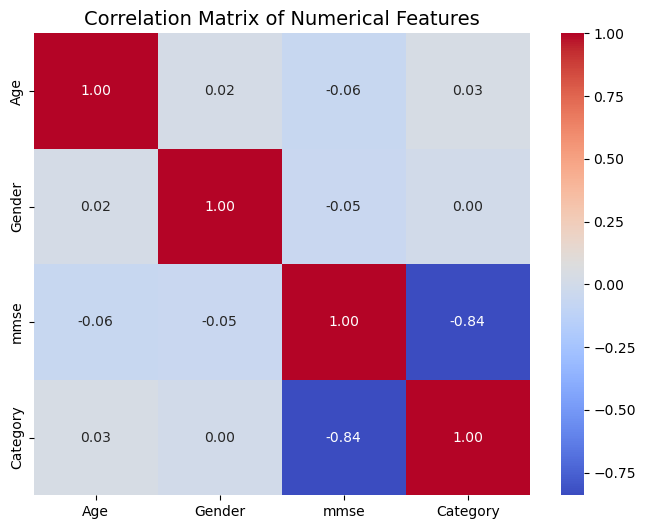

In [539]:
#analyze correlation between numerical parameters and dementia (Category) (we select only numerical columns)

numerical_columns = ['Age', 'Gender' , 'mmse', 'Category']
correlation_matrix = train[numerical_columns].corr()


plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features", fontsize=14)
plt.show()

From the correlation matrix we see:
- There is a strong negative correlation between MMSE and Category (-0.84), indicating that lower MMSE scores are strongly associated with dementia.
- The correlation between Age and Category is very weak (0.03), suggesting that age alone is not a significant predictor of dementia in this dataset.
- Gender has virtually no correlation with Category (0.00), meaning gender does not play a predictive role in identifying dementia in this dataset.

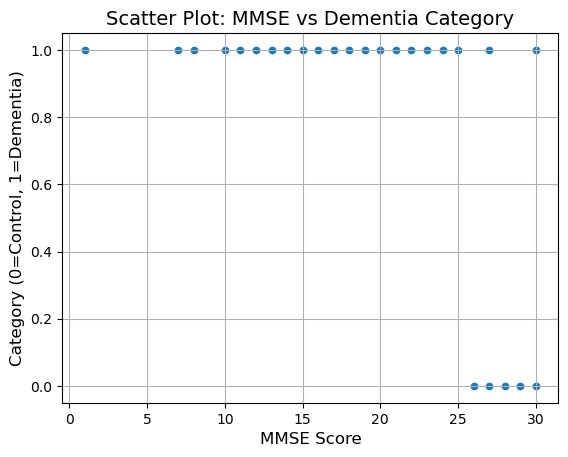

In [542]:
sns.scatterplot(x=train['mmse'], y=train['Category'])
plt.title("Scatter Plot: MMSE vs Dementia Category", fontsize=14)
plt.xlabel("MMSE Score", fontsize=12)
plt.ylabel("Category (0=Control, 1=Dementia)", fontsize=12)
plt.grid(True)
plt.show()

 MMSE is a powerful predictor!

#  3. Feature Extraction

Firstly, we apply the TF-IDF approach to our text datasets to convert it into numerical features, reflecting the importance of terms relative to their document and the entire corpus.

In [547]:
#initialize the TF-IDF Vectorizer (TfidfVectorizer includes a built-in tokenizer)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed

#fit on train data and transform both train and test
tfidf_train_features = tfidf_vectorizer.fit_transform(train['Transcript'])
tfidf_test_features = tfidf_vectorizer.transform(test['Transcript'])

#convert to dataframes 
tfidf_train_df = pd.DataFrame(tfidf_train_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_test_df = pd.DataFrame(tfidf_test_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

#print("Train TF-IDF DataFrame:")
#print(tfidf_train_df.head())

#print("\nTest TF-IDF DataFrame:")
#print(tfidf_test_df.head())

Secondly, we use BERT.

In [550]:
#load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [551]:
#function to extract embeddings from a text
def extract_bert_embeddings(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding

#apply the BERT extraction to the 'Transcript' column in train
bert_train_features = []
for text in train['Transcript']:
    bert_train_features.append(extract_bert_embeddings(text, tokenizer, model))


#apply the BERT extraction to the 'Transcript' column in test
bert_test_features = []
for text in test['Transcript']:
    bert_test_features.append(extract_bert_embeddings(text, tokenizer, model))

#convert to dataframes 
bert_test_df = pd.DataFrame(bert_test_features)
bert_train_df = pd.DataFrame(bert_train_features)


#print("Train BERT Embeddings DataFrame:")
#print(bert_train_df.head());

#print("\nTest BERT Embeddings DataFrame:")
#print(bert_test_df.head());

# 4. Classification models

## 4.1. Machine learning techniques

## Simple logistic regression based on `mmse`

We start with a simple logistic regression based on the single parameter `mmse`. We saw  that it is a powerful predictor of dementia so this first approach will give some basic performance to compare our NLP models with.

Accuracy on mmse: 0.8958333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90        24
           1       0.91      0.88      0.89        24

    accuracy                           0.90        48
   macro avg       0.90      0.90      0.90        48
weighted avg       0.90      0.90      0.90        48



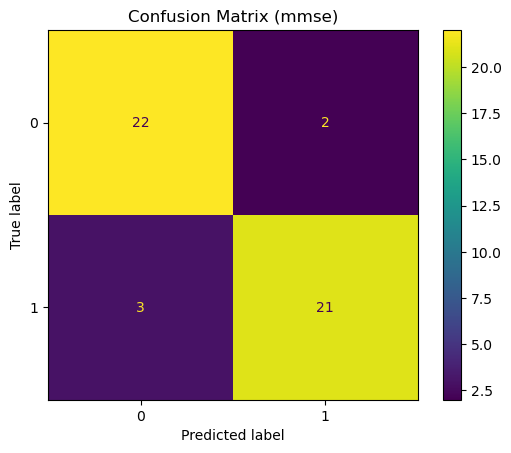

Model weights: [[-1.16990238]]
Model bias): [30.61183543]


In [557]:
# Use only the 'mmse' feature for training
X_train_mmse = train[['mmse']].values  
X_test_mmse = test[['mmse']].values    
y_train = train['Category'].values     
y_test = test['Category'].values      

#initialize and train the logistic regression model
log_reg_mmse = LogisticRegression(random_state=42)  # Create a Logistic Regression model
log_reg_mmse.fit(X_train_mmse, y_train)  # Train the model on the training data

#make predictions on the test dataset
y_pred_mmse = log_reg_mmse.predict(X_test_mmse)  # Predict categories for the test data

#evaluate the model
print("Accuracy on mmse:", accuracy_score(y_test, y_pred_mmse))  # Print the accuracy score
print("\nClassification Report:\n", classification_report(y_test, y_pred_mmse))  # Detailed metrics (precision, recall, F1-score)

#confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_mmse)
ConfusionMatrixDisplay(conf_matrix, display_labels=log_reg_mmse.classes_).plot()
plt.title("Confusion Matrix (mmse)")
plt.show()

#we can optionally see the optimal values of weights and bias
print("Model weights:", log_reg_mmse.coef_)
print("Model bias):", log_reg_mmse.intercept_)

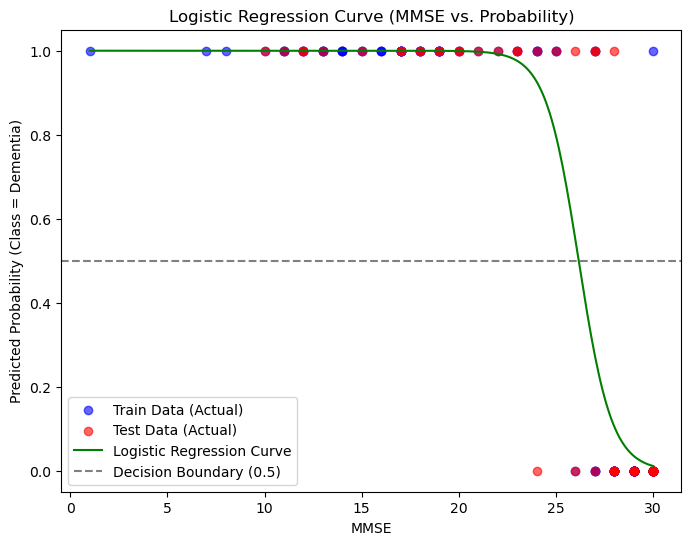

In [559]:
# Generate a range of values for mmse to plot the curve
mmse_range = np.linspace(X_train_mmse.min(), X_train_mmse.max(), 300).reshape(-1, 1)

# Predict probabilities for the range of mmse values
predicted_probs = log_reg_mmse.predict_proba(mmse_range)[:, 1]  # Probability for class 1 (Dementia)

# Plot the logistic regression curve
plt.figure(figsize=(8, 6))
plt.scatter(X_train_mmse, y_train, color='blue', label='Train Data (Actual)', alpha=0.6)
plt.scatter(X_test_mmse, y_test, color='red', label='Test Data (Actual)', alpha=0.6)
plt.plot(mmse_range, predicted_probs, color='green', label='Logistic Regression Curve')
plt.axhline(0.5, color='gray', linestyle='--', label='Decision Boundary (0.5)')
plt.xlabel('MMSE')
plt.ylabel('Predicted Probability (Class = Dementia)')
plt.title('Logistic Regression Curve (MMSE vs. Probability)')
plt.legend()
plt.show()

The logistic regression model based on `mmse` parameter achieved 90% accuracy, with precision, recall, and F1-scores around 0.9 for both classes. It performed well overall, though a few misclassifications occurred (2 for class 0 and 3 for class 1).

## Logistic regression for TF-IDF features

Now we again apply logistic regression but using the numerical features which we got from the texts in the `Transcript` column using TF-IDF approach.

Accuracy on test set: 0.875
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        24
           1       0.88      0.88      0.88        24

    accuracy                           0.88        48
   macro avg       0.88      0.88      0.88        48
weighted avg       0.88      0.88      0.88        48



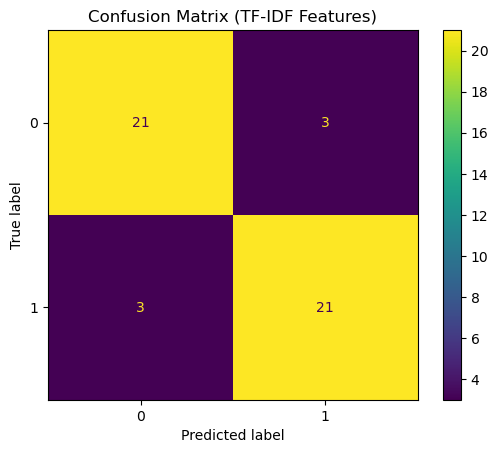

In [564]:
#train Logistic Regression on TF-IDF features
log_reg_tfidf = LogisticRegression(random_state=42, max_iter=1000)  
log_reg_tfidf.fit(tfidf_train_df, y_train) 

#pefrormance on the test data
y_pred_tfidf = log_reg_tfidf.predict(tfidf_test_df)

#classification report
print("Accuracy on test set:", accuracy_score(y_test, y_pred_tfidf))  
print("Classification Report:")
print(classification_report(y_test, y_pred_tfidf))

#confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_tfidf)
ConfusionMatrixDisplay(conf_matrix, display_labels=log_reg_tfidf.classes_).plot()
plt.title("Confusion Matrix (TF-IDF Features)")
plt.show()

We see that accuracy of the model as well as precision, recall and f1-score are a bit worse then for our base `mmse` model.

## Logistic regression for BERT features

Now we apply logistic regression but using the numerical features which we got from the texts in the `Transcript` column using BERT approach.

Accuracy on test set: 0.75
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76        24
           1       0.77      0.71      0.74        24

    accuracy                           0.75        48
   macro avg       0.75      0.75      0.75        48
weighted avg       0.75      0.75      0.75        48



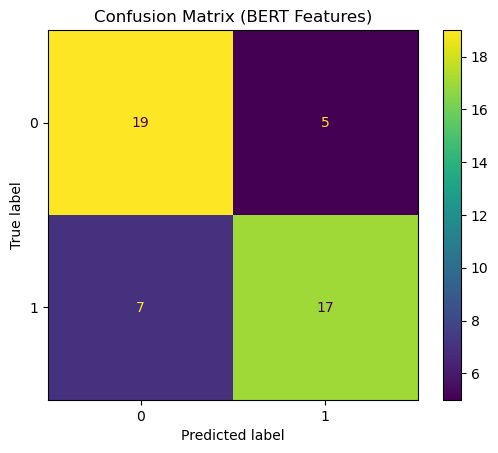

In [569]:
log_reg_bert = LogisticRegression(max_iter=1000, random_state=42)
log_reg_bert.fit(bert_train_df, y_train)

y_pred_bert = log_reg_bert.predict(bert_test_df)

print("Accuracy on test set:", accuracy_score(y_test, y_pred_bert)) 
print("Classification Report:")
print(classification_report(y_test, y_pred_bert))

conf_matrix = confusion_matrix(y_test, y_pred_bert)
ConfusionMatrixDisplay(conf_matrix, display_labels=log_reg_bert.classes_).plot()
plt.title("Confusion Matrix (BERT Features)")
plt.show()

This approach works significantly worse then the one base on TF-IDF features.

## SVM for TF-IDF features

We apply the Support Vector Machine technique using the features extracted with TF-IDF.

Accuracy on mmse: 0.8958333333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        24
           1       0.91      0.88      0.89        24

    accuracy                           0.90        48
   macro avg       0.90      0.90      0.90        48
weighted avg       0.90      0.90      0.90        48



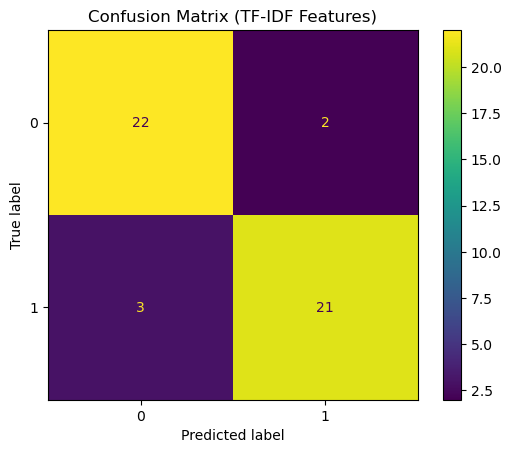

In [574]:
#initialize the SVM classifier 
svm_model = SVC(kernel='rbf', random_state=42) #we use radial basis function kernel as it has better performans than the linear one.

#fit the SVM model on the TF-IDF features
svm_model.fit(tfidf_train_df, y_train)

#make predictions on the test set
y_pred_svm_on_tfidf = svm_model.predict(tfidf_test_df)


print("Accuracy on mmse:", accuracy_score(y_test, y_pred_svm_on_tfidf))  # Print the accuracy scor
print("Classification Report:")
print(classification_report(y_test, y_pred_svm_on_tfidf))


conf_matrix = confusion_matrix(y_test, y_pred_svm_on_tfidf)
ConfusionMatrixDisplay(conf_matrix, display_labels=svm_model.classes_).plot()
plt.title("Confusion Matrix (TF-IDF Features)")
plt.show()

## SVM for BERT features

Accuracy on mmse: 0.75
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        24
           1       0.75      0.75      0.75        24

    accuracy                           0.75        48
   macro avg       0.75      0.75      0.75        48
weighted avg       0.75      0.75      0.75        48



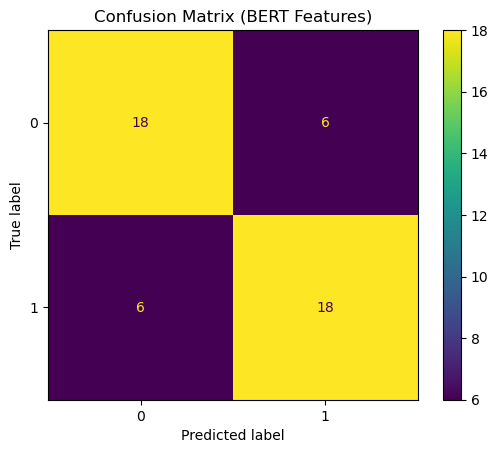

In [577]:
svm_model_bert = SVC(kernel='rbf', random_state=42)

svm_model_bert.fit(bert_train_features, y_train)

y_pred_svm_on_bert = svm_model_bert.predict(bert_test_features)


print("Accuracy on mmse:", accuracy_score(y_test, y_pred_svm_on_bert))  # Print the accuracy scor
print("Classification Report:")
print(classification_report(y_test, y_pred_svm_on_bert))

conf_matrix = confusion_matrix(y_test, y_pred_svm_on_bert)
ConfusionMatrixDisplay(conf_matrix, display_labels=svm_model_bert.classes_).plot()
plt.title("Confusion Matrix (BERT Features)")
plt.show()

We observe that the performance of the SVM model is a bit better than the performance of the logistic regression. And again the TF-IDF features worked significantly better that BERT features.

## 4.2. Deep learning techniques

### Feedforward neural network

We start with building a simple feedforward neural network for binary classification. The input layer takes the TF-IDF features. Each sample is represented as a vector derived from the TF-IDF matrix. The neural network has 2 layers: both are fully connected layer with 64 neurons and ReLU activation function. The output layer is a single neuron with a sigmoid activation function which produces the probability for binary classification. The loss function is Binary Cross-Entropy Loss. We apply 4-Fold Cross-Validation method.

Fold 1/4
Fold 1 Accuracy: 0.7778
Fold 2/4
Fold 2 Accuracy: 0.8148
Fold 3/4
Fold 3 Accuracy: 0.7037
Fold 4/4
Fold 4 Accuracy: 0.6296


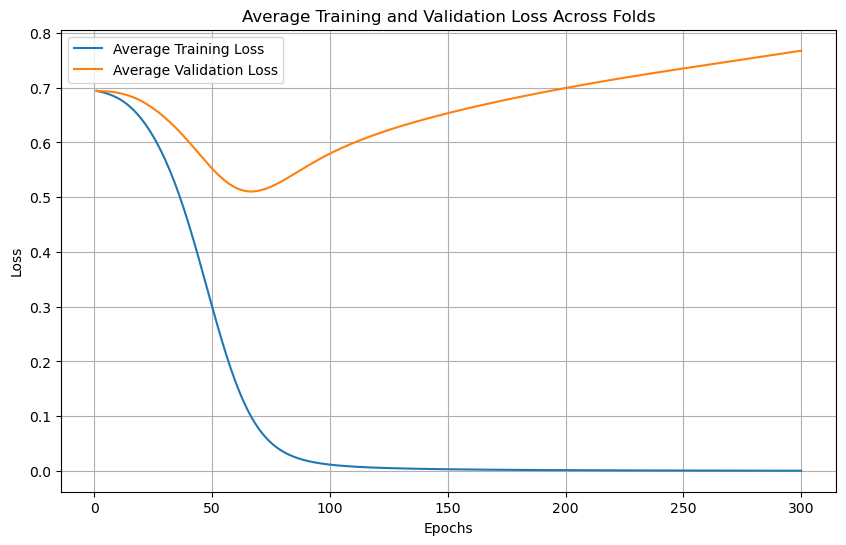


K-Fold Results:
Average Train Loss (Final Epoch): 0.0006
Average Validation Loss (Final Epoch): 0.7674
Average Accuracy: 0.7315
Accuracy on test set: 0.8125
Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.92      0.83        24
         1.0       0.89      0.71      0.79        24

    accuracy                           0.81        48
   macro avg       0.83      0.81      0.81        48
weighted avg       0.83      0.81      0.81        48



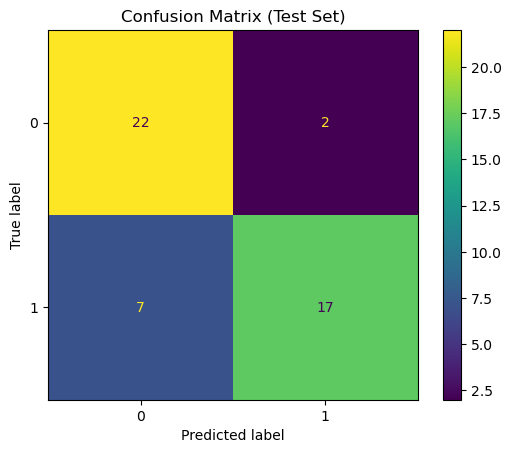

In [469]:
#convert TF-IDF features and labels to PyTorch tensors
X_tensor = torch.tensor(tfidf_train_df.values, dtype=torch.float32)
y_tensor = torch.tensor(train['Category'].values, dtype=torch.float32).unsqueeze(1)

#number of folds for K-fold cross validation
k = 4
kf = KFold(n_splits=k, shuffle=True, random_state=42)

#store losses and accuracies for each fold
all_train_losses = []
all_val_losses = []
all_accuracies = []

#function for K-Fold Cross-Validation
num_epochs = 300
avg_train_loss_per_epoch = np.zeros(num_epochs)
avg_val_loss_per_epoch = np.zeros(num_epochs)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor)):
    print(f"Fold {fold + 1}/{k}")
    X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
    y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]
    
    # define the model for each fold
    class SimpleNN(nn.Module):
        def __init__(self, input_size):
            super(SimpleNN, self).__init__()
            self.fc1 = nn.Linear(input_size, 64)
            self.relu1 = nn.ReLU()
            self.fc2 = nn.Linear(64, 64)
            self.fc3 = nn.Linear(64, 1)
            self.sigmoid = nn.Sigmoid()
        
        def forward(self, x):
            x = self.fc1(x)
            x = self.relu1(x)
            x = self.fc2(x)
            x = self.relu1(x)
            x = self.fc3(x)
            x = self.sigmoid(x)
            return x

    input_size = tfidf_train_df.shape[1]
    model = SimpleNN(input_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # training loop for each fold
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        train_loss = criterion(outputs, y_train)
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())
        
        #validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())
        
    avg_train_loss_per_epoch += np.array(train_losses) / k
    avg_val_loss_per_epoch += np.array(val_losses) / k

    #evaluate the model on validation set
    with torch.no_grad():
        val_preds = (model(X_val) > 0.5).float()
        accuracy = (val_preds.eq(y_val).sum().item()) / y_val.shape[0]
        all_accuracies.append(accuracy)
        print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")

#plot average Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), avg_train_loss_per_epoch, label="Average Training Loss")
plt.plot(range(1, num_epochs + 1), avg_val_loss_per_epoch, label="Average Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Average Training and Validation Loss Across Folds")
plt.legend()
plt.grid(True)
plt.show()

#summary of K-Fold results
print("\nK-Fold Results:")
print(f"Average Train Loss (Final Epoch): {avg_train_loss_per_epoch[-1]:.4f}")
print(f"Average Validation Loss (Final Epoch): {avg_val_loss_per_epoch[-1]:.4f}")
print(f"Average Accuracy: {np.mean(all_accuracies):.4f}")

#convert test data to PyTorch tensors
X_test_tensor = torch.tensor(tfidf_test_df.values, dtype=torch.float32)
y_test_tensor = torch.tensor(test['Category'].values, dtype=torch.float32).unsqueeze(1)

#evaluate the last trained model on the test set
model.eval()  
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_class = (y_pred > 0.5).float()  #convert probabilities to binary classes

#classification report
y_test_np = y_test_tensor.numpy().flatten()
y_pred_np = y_pred_class.numpy().flatten()

print("Accuracy on test set:", accuracy_score(y_test_np, y_pred_np))  # Print the accuracy score
print("Classification Report:")
print(classification_report(y_test_np, y_pred_np))

conf_matrix = confusion_matrix(y_test_np, y_pred_np)
ConfusionMatrixDisplay(conf_matrix, display_labels=[0, 1]).plot()
plt.title("Confusion Matrix (Test Set)")
plt.show()

The neural network achieved an accuracy of 77% on the test set. It performed well for classifying negative samples with high recall and reasonable precision. For positive samples, precision is high, but recall is low, indicating some false negatives.

Training and validation loss trends suggest overfitting, with validation loss increasing after some epochs. The small dataset size limits model performance. Improvements could involve increasing the dataset size, using regularization, or simplifying the model.

We also experimented with BERT embeddings as input features; however, the results were less accurate than those achieved with TF-IDF, likely due to the small dataset size and limited fine-tuning of the model.

### Transformer-based model (BERT) 

Now we use a pre-trained BERT model. First, the BertTokenizer is used to preprocess the text data, converting it into tokenized inputs compatible with the BERT model. The BertClassifier model initializes a pre-trained BERT model (bert-base-uncased) and adds a classification head (a fully connected layer with a sigmoid activation) for binary classification. The binary cross-entropy loss function (BCELoss) is used as the loss criterion.

In [471]:
#initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(texts, labels, tokenizer, max_len):
    # Convert texts into tokenized inputs
    inputs = tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )
    labels = torch.tensor(labels.values, dtype=torch.float32)
    return inputs, labels

#tokenize training and testing data
max_len = 128  # Maximum sequence length
train_inputs, train_labels = tokenize_data(train['Transcript'], train['Category'], tokenizer, max_len)
test_inputs, test_labels = tokenize_data(test['Transcript'], test['Category'], tokenizer, max_len)

In [354]:
#define the model
class BertClassifier(nn.Module):
    def __init__(self, pretrained_model_name, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        #add a classification layer
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        logits = self.classifier(cls_output)
        return self.sigmoid(logits)

In [392]:
model = BertClassifier(pretrained_model_name='bert-base-uncased', num_classes=1)  # 1 для бинарной классификации

criterion = nn.BCELoss()  #binary cross-entropy loss
optimizer = AdamW(model.parameters(), lr=2e-5)

/opt/anaconda3/envs/env_AI_project/lib/python3.8/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20, Train Loss: 0.7077, Val Loss: 0.6861
Epoch 2/20, Train Loss: 0.6829, Val Loss: 0.6784
Epoch 3/20, Train Loss: 0.6593, Val Loss: 0.6391
Epoch 4/20, Train Loss: 0.5873, Val Loss: 0.5895
Epoch 5/20, Train Loss: 0.4902, Val Loss: 0.5681
Epoch 6/20, Train Loss: 0.4329, Val Loss: 0.4653
Epoch 7/20, Train Loss: 0.2297, Val Loss: 0.6238
Epoch 8/20, Train Loss: 0.1181, Val Loss: 0.4481
Epoch 9/20, Train Loss: 0.0658, Val Loss: 0.5084
Epoch 10/20, Train Loss: 0.0648, Val Loss: 0.5836
Epoch 11/20, Train Loss: 0.0286, Val Loss: 1.1234
Epoch 12/20, Train Loss: 0.0193, Val Loss: 0.7783
Epoch 13/20, Train Loss: 0.0200, Val Loss: 0.9614
Epoch 14/20, Train Loss: 0.0357, Val Loss: 0.8191
Epoch 15/20, Train Loss: 0.0564, Val Loss: 1.0990
Epoch 16/20, Train Loss: 0.0342, Val Loss: 0.6483
Epoch 17/20, Train Loss: 0.0151, Val Loss: 0.7008
Epoch 18/20, Train Loss: 0.0091, Val Loss: 0.6838
Epoch 19/20, Train Loss: 0.0078, Val Loss: 0.7262
Epoch 20/20, Train Loss: 0.0252, Val Loss: 0.6982


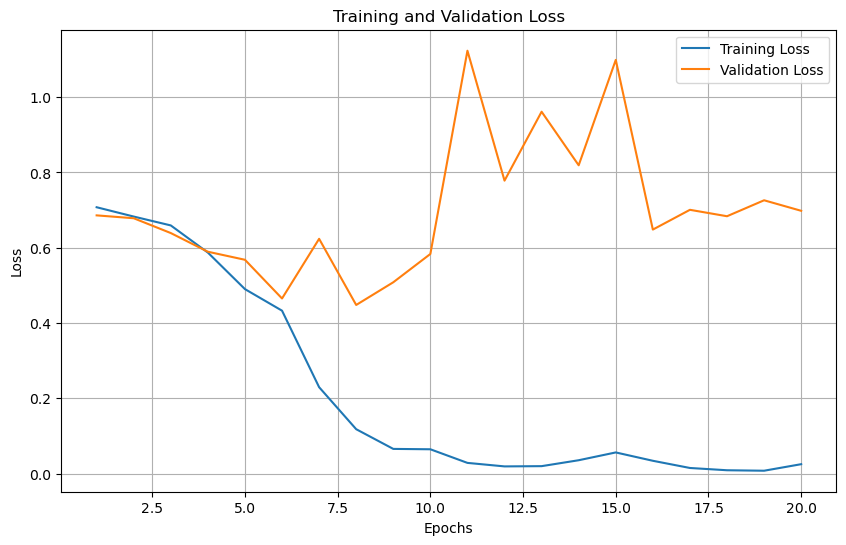

In [394]:
#сreate dataLoader for training and testing datasets
train_data = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
test_data = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_labels)

#initialize dataLoaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

#training parameters
num_epochs = 20
train_losses = []
val_losses = []

#training and evaluation loop
for epoch in range(num_epochs):
    #training phase
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    #save average training loss for the epoch
    train_losses.append(total_train_loss / len(train_loader))

    #evaluation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch

            #forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.squeeze(), labels)

            total_val_loss += loss.item()

    #save average validation loss for the epoch
    val_losses.append(total_val_loss / len(test_loader))

    #print epoch loss
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

#plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

Accuracy: 0.8541666666666666
              precision    recall  f1-score   support

         0.0       0.90      0.79      0.84        24
         1.0       0.81      0.92      0.86        24

    accuracy                           0.85        48
   macro avg       0.86      0.85      0.85        48
weighted avg       0.86      0.85      0.85        48



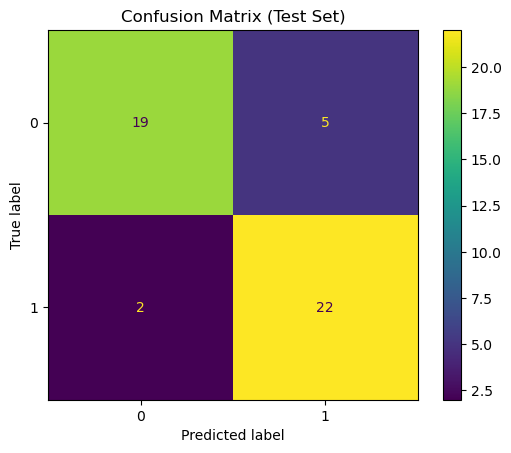

In [398]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = (outputs.squeeze() > 0.5).float() 
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds))

conf_matrix = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(conf_matrix, display_labels=[0, 1]).plot()
plt.title("Confusion Matrix (Test Set)")
plt.show()

We see that this model reaches the accuracy of 85% which is significantly better than the accuracy of the feedforward neural network. We again observe overfitting with validation loss increasing after some epochs.

# 5. Concluions

In this project, we explored various NLP techniques, including both machine learning and deep learning methods, to predict the presence or absence of dementia in patients based on transcripts of their speech. We began with data preprocessing, which involved handling missing values in the training set, converting categorical variables into binary values, and text preprocessing (removing stop words, performing lemmatization, etc.).

We then conducted data analysis and confirmed that the dataset is balanced in terms of gender, age, and positive/negative cases.

To apply NLP techniques to the transcripts, we transformed the textual data into numerical features using two approaches: TF-IDF and BERT embeddings.

The machine learning techniques we employed included logistic regression and SVM. Both methods demonstrated strong performance with the TF-IDF feature extraction approach, achieving accuracy and F1 scores close to 0.9. However, the BERT-based feature extraction approach performed significantly worse, likely due to the small size of the training set.

In the deep learning experiments, we initially implemented a simple feedforward neural network, which achieved an accuracy of 77% using TF-IDF features. On the other hand, the pre-trained Transformer-based BERT model achieved a test accuracy of 85%. However, both deep learning approaches showed signs of overfitting, likely due to the limited size of the dataset.

Overall, the best performance was achieved using the SVM method, with results comparable to predicting dementia status based on the MMSE test alone.